1. Select only the records corresponding to failed inspections (see the "results" column).

In [2]:
import pandas as pd

# Loading the data
url = "https://storage.googleapis.com/adsp-nlp-open/data/Food_Inspections_20250325.csv"
data = pd.read_csv(url)

# Here we filter for failed inspections only
failed = data[data['Results'].str.lower() == 'fail']

In [3]:
failed.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,1068208,CHINA COURT RESTAURANT,CHINA COURT RESTAURANT,2141795.0,Restaurant,Risk 1 (High),1146 N MILWAUKEE AVE,CHICAGO,IL,60642.0,03/14/2012,License Re-Inspection,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.902462,-87.665306,"(41.902462266949634, -87.66530609467256)"
5,1072529,GRESHAM ELEMENTARY SCHOOL,GRESHAM ELEMENTARY SCHOOL,23451.0,School,Risk 1 (High),8524 S Green (832W),CHICAGO,IL,60620.0,09/05/2013,Canvass,Fail,12. HAND WASHING FACILITIES: WITH SOAP AND SAN...,41.738913,-87.645062,"(41.73891334027122, -87.6450616939937)"
6,1084236,THE JIBARITO STOP,THE JIBARITO STOP,2156722.0,Mobile Food Dispenser,Risk 3 (Low),2007-2009 S DAMEN AVE,CHICAGO,IL,60608.0,05/25/2012,License,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.854695,-87.675765,"(41.854694701707345, -87.67576513516751)"
7,1084239,MANJARES AL EXPRESS,MANJARES AL EXPRESS,2021538.0,Restaurant,Risk 1 (High),2226-2230 S ASHLAND AVE,CHICAGO,IL,60608.0,05/29/2012,Complaint,Fail,2. FACILITIES TO MAINTAIN PROPER TEMPERATURE -...,41.851398,-87.666166,"(41.851397799712196, -87.66616621226514)"
8,1084242,CHISCREAM,CHISCREAM,2152278.0,Mobile Food Dispenser,Risk 3 (Low),324 N LEAVITT ST,CHICAGO,IL,60612.0,06/04/2012,License,Fail,"1. SOURCE SOUND CONDITION, NO SPOILAGE, FOODS ...",41.887434,-87.681849,"(41.88743405025222, -87.68184949426895)"


2. Use regular expressions to extract the regulation description and inspector comments from the "violations" columns. Every record representations a restaurant inspection. The "violations" column contains "|"-separated violations encountered during inspection (there can be more than one violation during a given inspection). Each violation generally consists of a regulation code, regulation description, and comments describing how the regulation was violated.

In [4]:
import re

# We create a function to extract violations
def extract_violations(text):
    if pd.isnull(text):
        return []
    
    violations = text.split('|')
    result = []
    for v in violations:
        match = re.match(r'^\s*\d+\.\s*([^:]+):?\s*(.*)$', v.strip())
        if match:
            desc = match.group(1).strip()
            comment = match.group(2).strip()
            result.append((desc, comment))
    return result

# Applying the extractions
failed['parsed_violations'] = failed['Violations'].apply(extract_violations)

# Flattening regulation descriptions
all_violations = failed['parsed_violations'].explode().dropna()
descriptions = all_violations.apply(lambda x: x[0] if isinstance(x, tuple) else None).dropna()

/var/folders/4g/7cwxt52n09sb7vzyh6tzj3w00000gn/T/ipykernel_61491/2887062030.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failed['parsed_violations'] = failed['Violations'].apply(extract_violations)


3. Count how many times each regulation description occurred in the table and visualize the top 10 most frequent regulation descriptions.

/var/folders/4g/7cwxt52n09sb7vzyh6tzj3w00000gn/T/ipykernel_61491/1798846184.py:9: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


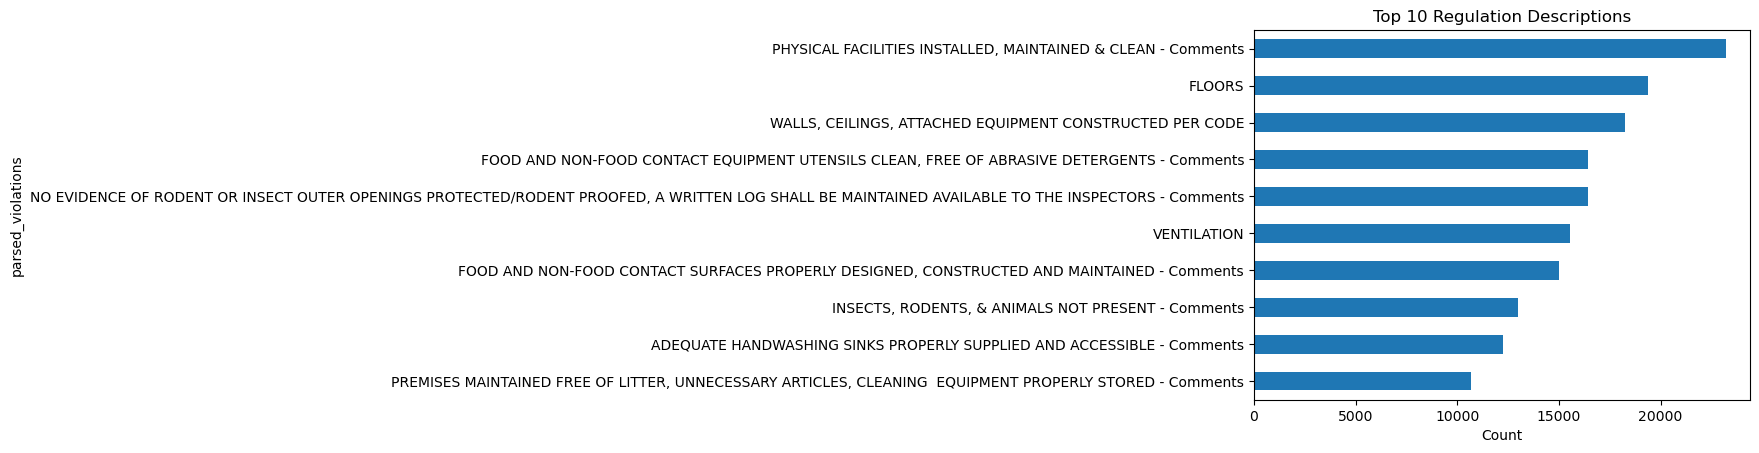

In [5]:
import matplotlib.pyplot as plt

# Counting frequencies
top_violations = descriptions.value_counts().head(10)

top_violations.plot(kind='barh', title='Top 10 Regulation Descriptions')
plt.xlabel('Count')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

4. Tokenize the comments and provide a count of the top 10:
   1. Raw tokens
   2. Preprocessed tokens
   3. Preprocessed tokens + Porter stemmer
   4. Preprocessed tokens + Lancaster stemmer
   5. Preprocessed tokens + lemmatization
   
Briefly describe the differences in various tokens from (4).

In [6]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer
import string

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Flattening comments
comments = all_violations.apply(lambda x: x[1] if isinstance(x, tuple) else None).dropna()

# Here we are joining all comments into one big text
text = ' '.join(comments)

[nltk_data] Downloading package punkt to /Users/casey/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /Users/casey/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /Users/casey/nltk_data...


In [7]:
# Raw Tokens
raw_tokens = word_tokenize(text)

# Preprocessed Tokens (lowercase, remove punctuation and stopwords)
stop_words = set(stopwords.words('english'))
preprocessed_tokens = [w.lower() for w in raw_tokens if w.isalpha() and w.lower() not in stop_words]

# Porter Stemmer
porter = PorterStemmer()
porter_tokens = [porter.stem(w) for w in preprocessed_tokens]

# Lancaster Stemmer
lancaster = LancasterStemmer()
lancaster_tokens = [lancaster.stem(w) for w in preprocessed_tokens]

# Lemmatization
lemmatizer = WordNetLemmatizer()
lemmatized_tokens = [lemmatizer.lemmatize(w) for w in preprocessed_tokens]

# Counting and displaying top 10 for each
from collections import Counter

def display_top(tokens, title):
    print(f"\nTop 10 {title} Tokens:")
    for word, count in Counter(tokens).most_common(10):
        print(f"{word}: {count}")

display_top(raw_tokens, "Raw")
display_top(preprocessed_tokens, "Preprocessed")
display_top(porter_tokens, "Porter Stemmed")
display_top(lancaster_tokens, "Lancaster Stemmed")
display_top(lemmatized_tokens, "Lemmatized")

LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/Users/casey/nltk_data'
    - '/opt/anaconda3/nltk_data'
    - '/opt/anaconda3/share/nltk_data'
    - '/opt/anaconda3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************
